## Visualização da base

Importações

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, make_scorer, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

Base

In [ ]:
path = 'https://raw.githubusercontent.com/arthurgmm/ia_dataset/main/healthcare-dataset-stroke-data.csv'

dados = pd.read_csv(path)
dados.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


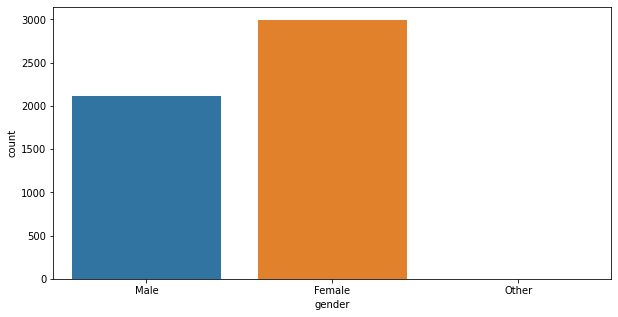

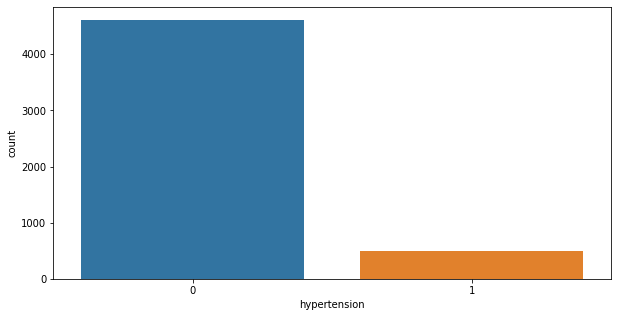

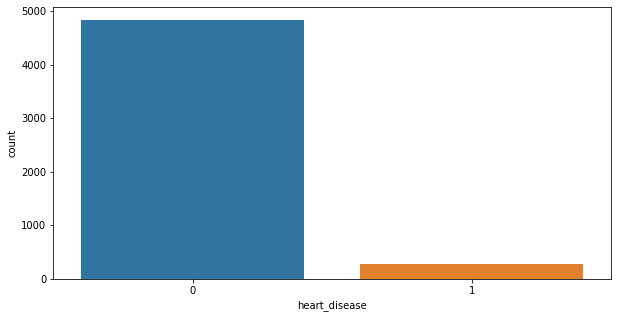

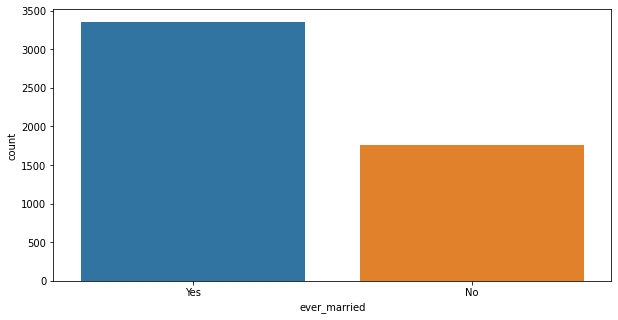

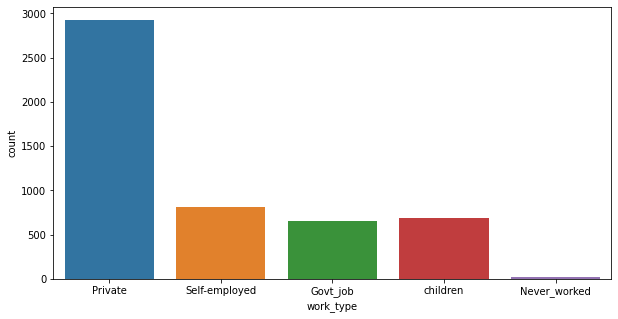

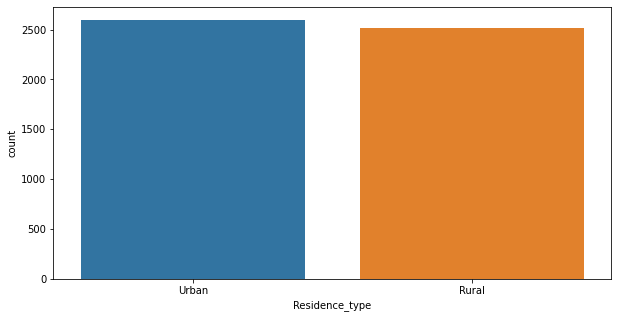

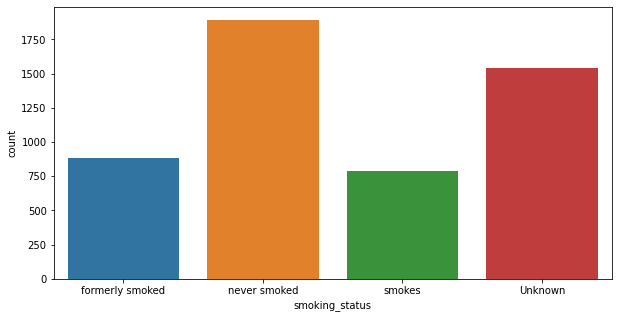

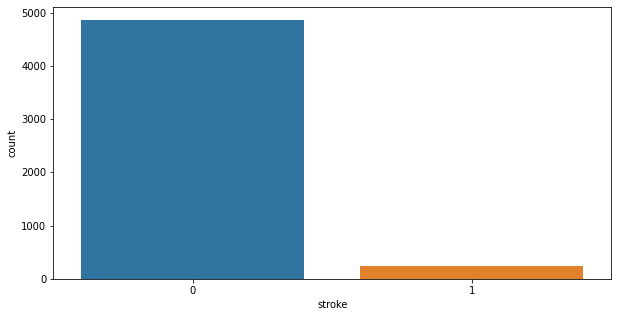

In [ ]:
dados_num=dados[['age','avg_glucose_level','bmi']]
dados_cat=dados[['gender', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 
                       'smoking_status', 'stroke']]

for cat in dados_cat:
    plt.figure(figsize=(10,5))
    sns.countplot(x = dados[cat])
    plt.show()

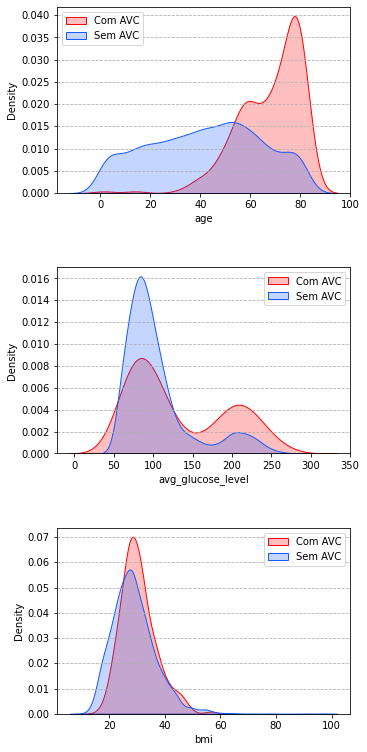

In [ ]:
fig = plt.figure(figsize=(20,13))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.4, hspace=0.4)

ax0 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[2,0])
axes=[ax0,ax2,ax4]

sns.kdeplot(ax=ax0,x=dados.loc[dados['stroke']==1]['age'],color='#ff0000',label='Com AVC',shade=True)
sns.kdeplot(ax=ax0,x=dados.loc[dados['stroke']==0]['age'],color='#145bff',label='Sem AVC',shade=True)
ax0.legend(loc = 'upper left')
ax0.grid(linestyle='--', axis='y')

sns.kdeplot(ax=ax2,x=dados.loc[dados['stroke']==1]['avg_glucose_level'],color='#ff0000',label='Com AVC',shade=True)
sns.kdeplot(ax=ax2,x=dados.loc[dados['stroke']==0]['avg_glucose_level'],color='#145bff',label='Sem AVC',shade=True)
ax2.legend(loc = 'upper right')
ax2.grid(linestyle='--', axis='y')

sns.kdeplot(ax=ax4,x=dados.loc[dados['stroke']==1]['bmi'],color='#ff0000',label='Com AVC',shade=True)
sns.kdeplot(ax=ax4,x=dados.loc[dados['stroke']==0]['bmi'],color='#145bff',label='Sem AVC',shade=True)
ax4.legend(loc = 'upper right')
ax4.grid(linestyle='--', axis='y')

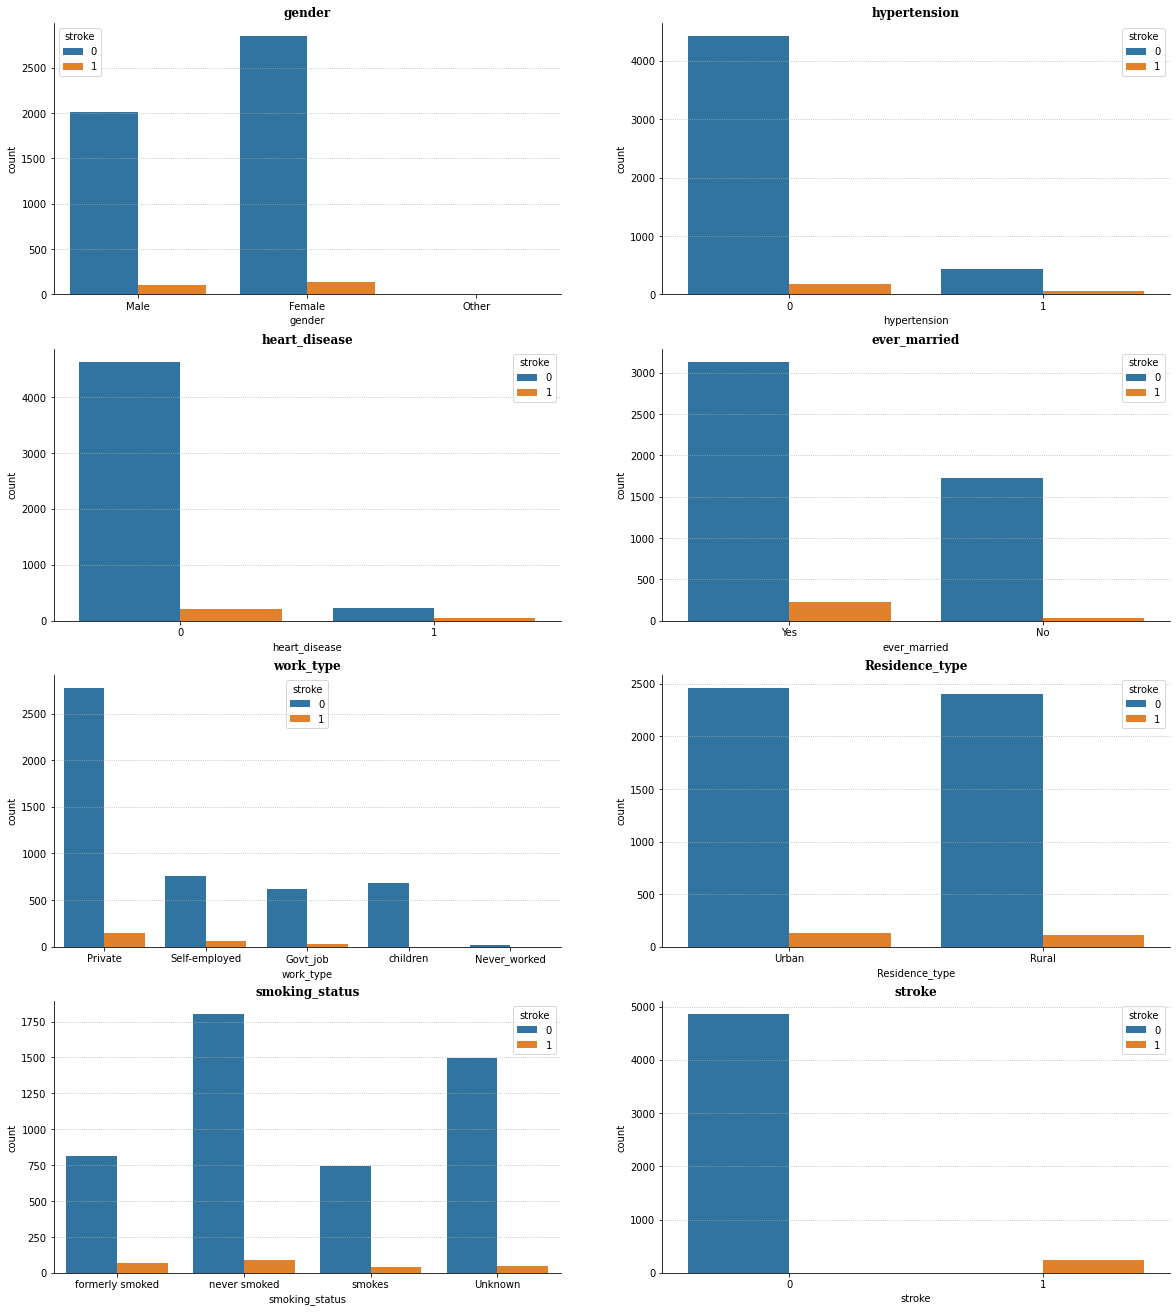

In [ ]:
dados_cat=dados[['gender', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 
                       'smoking_status', 'stroke']]
fig=plt.figure(figsize=(20,23))
for indx,val in enumerate(dados_cat.columns):
    ax=plt.subplot(4,2,indx+1)
    ax.set_title(val,fontweight='bold',fontfamily='serif')
    for i in ['top','right']:
        ax.spines[i].set_visible(False)
    ax.grid(linestyle=':',axis='y')
    sns.countplot(dados_cat[val],hue=dados['stroke'])

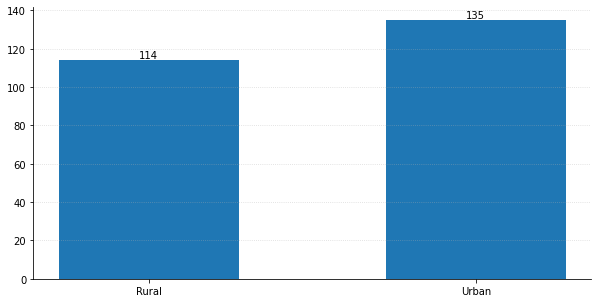

In [ ]:
# Smoking Type and Stroke
pd_stroke = pd.pivot_table(data=dados[dados['stroke']==1],index=dados['Residence_type'],values='stroke',aggfunc='count').reset_index()
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.bar(pd_stroke['Residence_type'],pd_stroke['stroke'],width=0.55,linewidth=0.7)
for idx,val in enumerate(pd_stroke['stroke']):
    ax.text(idx,val+1,round(val,1),horizontalalignment='center')
ax.grid(linestyle=':',axis='y',alpha=0.5)
for i in ['top','right']:
    ax.spines[i].set_visible(False)

## Etapas de pré-processamento

In [ ]:
dados = dados.drop(columns=['id'])

In [ ]:
dados['smoking_status'].replace('Unknown', np.nan, inplace=True)
dados.isna().sum()

gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64

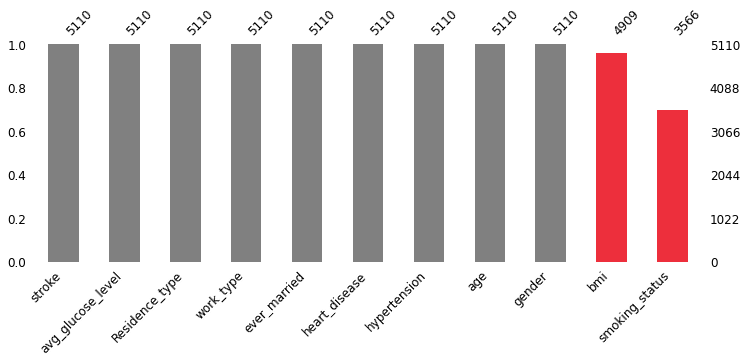

In [ ]:
color = ['grey','grey','grey','grey','grey','grey','grey','grey','grey','#ed2f3c','#ed2f3c']
msno.bar(dados, sort = 'descending', 
         figsize = (12,4),
         fontsize = 12,
         color = color, 
         labels = 'off',filter = 'top')

In [ ]:
dados['bmi'] = dados['bmi'].fillna(round(dados['bmi'].median(), 2))
dados['smoking_status'].fillna(dados['smoking_status'].mode()[0], inplace = True)

In [ ]:
dados.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

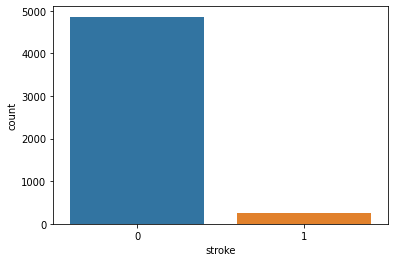

In [ ]:
sns.countplot(x='stroke', data=dados)

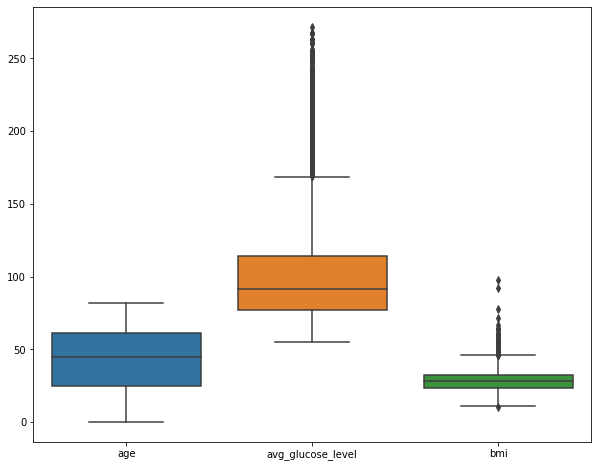

In [ ]:
plt.figure(figsize=(10, 8))
sns.boxplot(data = dados[["age","avg_glucose_level","bmi"]])

## Teste do modelo

Base desbalanceada

In [ ]:
X = dados[["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"]]
y = dados["stroke"]

originalclass = []
predictedclass = []

X = pd.get_dummies(X,drop_first=True)

def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred)

modelo = DecisionTreeClassifier()
scores = cross_val_score(modelo, X, y, cv=10, scoring=make_scorer(classification_report_with_accuracy_score))
print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4861
           1       0.14      0.17      0.15       249

    accuracy                           0.91      5110
   macro avg       0.55      0.56      0.55      5110
weighted avg       0.92      0.91      0.91      5110



Base balanceada (Oversampling)

In [ ]:
classifier = DecisionTreeClassifier(random_state=42)
X = dados[["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"]]
y = dados["stroke"]

originalclass = []
predictedclass = []

X = pd.get_dummies(X,drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=2)

kf = KFold(n_splits=10)
for train, test in kf.split(X_train, y_train):
    pipeline = make_pipeline_imb(SMOTE(), classifier)
    model = pipeline.fit(X_train.iloc[train], y_train.iloc[train])
    prediction = model.predict(X_train.iloc[test])

    originalclass.extend(y_train.iloc[test])
    predictedclass.extend(prediction)

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3646
           1       0.12      0.26      0.17       186

    accuracy                           0.88      3832
   macro avg       0.54      0.58      0.55      3832
weighted avg       0.92      0.88      0.90      3832



In [ ]:
classifier = DecisionTreeClassifier
X = dados[["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"]]
y = dados["stroke"]

originalclass = []
predictedclass = []

X = pd.get_dummies(X,drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=2)

kf = KFold(n_splits=25)

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index] 
    sm = SMOTE()
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
    model = DecisionTreeClassifier()
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred = model.predict(X_test)

    originalclass.extend(y_test)
    predictedclass.extend(y_pred)

print(classification_report(originalclass, predictedclass))

AttributeError: ignored

Base balanceada (Undersampling)

In [ ]:
X = dados[["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"]]
y = dados["stroke"]

originalclass = []
predictedclass = []

X = pd.get_dummies(X,drop_first=True)

models = {
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

for m in models:
  model = models[m]
  kf = KFold(n_splits=10)
  X, y = NearMiss().fit_sample(X_train, y_train)
  for train, test in kf.split(X, y):
      pipeline = make_pipeline(model)
      model = pipeline.fit(X[train], y[train])
      prediction = model.predict(X[test])

      originalclass.extend(y[test])
      predictedclass.extend(prediction)
  print(classification_report(originalclass, predictedclass))
  originalclass = []
  predictedclass = []

AttributeError: ignored

In [ ]:
classifier = RandomForestClassifier(random_state=42)
X = dados[["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"]]
y = dados["stroke"]

originalclass = []
predictedclass = []

X = pd.get_dummies(X,drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

kf = KFold(n_splits=10)
X, y = NearMiss().fit_sample(X_train, y_train)
for train, test in kf.split(X, y):
    pipeline = make_pipeline(classifier)
    model = pipeline.fit(X[train], y[train])
    prediction = model.predict(X[test])

    originalclass.extend(y[test])
    predictedclass.extend(prediction)

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

           0       0.59      0.61      0.60       236
           1       0.60      0.58      0.59       236

    accuracy                           0.59       472
   macro avg       0.59      0.59      0.59       472
weighted avg       0.59      0.59      0.59       472



Score de modelos com a base desbalanceada

In [ ]:
X = dados[["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"]]
y = dados["stroke"]

originalclass = []
predictedclass = []

X = pd.get_dummies(X,drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

models = {
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'SupportVectorMachine': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'Stochastic Gradient Descent':  SGDClassifier(max_iter=5000, random_state=0),
}

def classification_report_with_accuracy_score(y_true, y_pred):
  originalclass.extend(y_true)
  predictedclass.extend(y_pred)
  return accuracy_score(y_true, y_pred)

for m in models:
  model = models[m]
  scores = cross_val_score(model, X, y, cv=10, scoring=make_scorer(classification_report_with_accuracy_score))
  print(classification_report(originalclass, predictedclass))
  originalclass = []
  predictedclass = []

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4861
           1       0.27      0.01      0.02       249

    accuracy                           0.95      5110
   macro avg       0.61      0.51      0.50      5110
weighted avg       0.92      0.95      0.93      5110

              precision    recall  f1-score   support

           0       1.00      0.39      0.56      4861
           1       0.08      0.98      0.14       249

    accuracy                           0.42      5110
   macro avg       0.54      0.69      0.35      5110
weighted avg       0.95      0.42      0.54      5110

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4861
           1       0.24      0.03      0.06       249

    accuracy                           0.95      5110
   macro avg       0.59      0.51      0.51      5110
weighted avg       0.92      0.95      0.93      5110

              preci

Otimização de parâmetros (Undersampling)

In [ ]:
knn_model = KNeighborsClassifier()

parameters = {'n_neighbors': [2,3,5,7,9,11,15,20],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
             'weights': ['uniform', 'distance'],
             'metric': ['manhattan', 'euclidean', 'minkowski', 'cosine', 'jaccard', 'hamming']
             }

X, y = NearMiss().fit_sample(X_train, y_train)
gcv = GridSearchCV(knn_model, parameters, cv=5, verbose = 1, n_jobs = -1).fit(X, y)

print(f'GridSearchView Best Score: {gcv.best_score_*100}')
print(f'GridSearchView Best Estimator: {gcv.best_estimator_}')
print(f'GridSearchView Best Params: {gcv.best_params_}')

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 988 tasks      | elapsed:    3.2s


GridSearchView Best Score: 67.78735632183907
GridSearchView Best Estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')
GridSearchView Best Params: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:    5.5s finished


In [ ]:
X = dados[["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"]]
y = dados["stroke"]

originalclass = []
predictedclass = []

X = pd.get_dummies(X,drop_first=True)

models = {
    'KNeighborsClassifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform'),
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

for m in models:
  model = models[m]
  kf = KFold(n_splits=10)
  X, y = NearMiss().fit_sample(X_train, y_train)
  for train, test in kf.split(X, y):
      pipeline = make_pipeline(model)
      model = pipeline.fit(X[train], y[train])
      prediction = model.predict(X[test])

      originalclass.extend(y[test])
      predictedclass.extend(prediction)
  print(classification_report(originalclass, predictedclass))
  originalclass = []
  predictedclass = []

              precision    recall  f1-score   support

           0       0.60      0.86      0.71       220
           1       0.75      0.42      0.54       220

    accuracy                           0.64       440
   macro avg       0.67      0.64      0.62       440
weighted avg       0.67      0.64      0.62       440



In [ ]:
ada_model = AdaBoostClassifier()

parameters = {'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1]}

X, y = NearMiss().fit_sample(X_train, y_train)
gcv = GridSearchCV(ada_model, parameters, cv=5, verbose = 1, n_jobs = -1).fit(X, y)

print(f'GridSearchView Best Score: {gcv.best_score_*100}')
print(f'GridSearchView Best Estimator: {gcv.best_estimator_}')
print(f'GridSearchView Best Params: {gcv.best_params_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.1min finished


GridSearchView Best Score: 68.63636363636364
GridSearchView Best Estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                   learning_rate=0.001, n_estimators=2000, random_state=None)
GridSearchView Best Params: {'learning_rate': 0.001, 'n_estimators': 2000}


In [ ]:
X = dados[["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"]]
y = dados["stroke"]

originalclass = []
predictedclass = []

X = pd.get_dummies(X,drop_first=True)

models = {
    'AdaBoostClassifier': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                   learning_rate=0.001, n_estimators=2000, random_state=None),
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

for m in models:
  model = models[m]
  kf = KFold(n_splits=10)
  X, y = NearMiss().fit_sample(X_train, y_train)
  for train, test in kf.split(X, y):
      pipeline = make_pipeline(model)
      model = pipeline.fit(X[train], y[train])
      prediction = model.predict(X[test])

      originalclass.extend(y[test])
      predictedclass.extend(prediction)
  print(classification_report(originalclass, predictedclass))
  originalclass = []
  predictedclass = []

              precision    recall  f1-score   support

           0       0.62      0.82      0.71       225
           1       0.73      0.50      0.60       225

    accuracy                           0.66       450
   macro avg       0.68      0.66      0.65       450
weighted avg       0.68      0.66      0.65       450



In [ ]:
tree_model = DecisionTreeClassifier()

parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

X, y = NearMiss().fit_sample(X_train, y_train)
gcv = GridSearchCV(tree_model, parameters, cv=5, verbose = 1, n_jobs = -1).fit(X, y)

print(f'GridSearchView Best Score: {gcv.best_score_*100}')
print(f'GridSearchView Best Estimator: {gcv.best_estimator_}')
print(f'GridSearchView Best Params: {gcv.best_params_}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


GridSearchView Best Score: 69.33333333333334
GridSearchView Best Estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
GridSearchView Best Params: {'criterion': 'gini', 'max_depth': 6}


[Parallel(n_jobs=-1)]: Done 166 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.2s finished


In [ ]:
X = dados[["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"]]
y = dados["stroke"]

originalclass = []
predictedclass = []

X = pd.get_dummies(X,drop_first=True)

models = {
    'DecisionTreeClassifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

for m in models:
  model = models[m]
  kf = KFold(n_splits=10)
  X, y = NearMiss().fit_sample(X_train, y_train)
  for train, test in kf.split(X, y):
      pipeline = make_pipeline(model)
      model = pipeline.fit(X[train], y[train])
      prediction = model.predict(X[test])

      originalclass.extend(y[test])
      predictedclass.extend(prediction)
  print(classification_report(originalclass, predictedclass))
  originalclass = []
  predictedclass = []

              precision    recall  f1-score   support

           0       0.59      0.73      0.65       232
           1       0.64      0.49      0.55       232

    accuracy                           0.61       464
   macro avg       0.61      0.61      0.60       464
weighted avg       0.61      0.61      0.60       464



Otimização de parâmetros (Desbalanceada)

In [ ]:
knn_model = KNeighborsClassifier()

parameters = {'n_neighbors': [2,3,5,7,9,11,15,20],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
             'weights': ['uniform', 'distance'],
             'metric': ['manhattan', 'euclidean', 'minkowski', 'cosine', 'jaccard', 'hamming']
             }

gcv = GridSearchCV(knn_model, parameters, cv=5, verbose = 1, n_jobs = -1).fit(X, y)

print(f'GridSearchView Best Score: {gcv.best_score_*100}')
print(f'GridSearchView Best Estimator: {gcv.best_estimator_}')
print(f'GridSearchView Best Params: {gcv.best_params_}')

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 646 tasks      | elapsed:    3.1s


GridSearchView Best Score: 69.17718560074802
GridSearchView Best Estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')
GridSearchView Best Params: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:    6.6s finished


In [ ]:
X = dados[["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"]]
y = dados["stroke"]

originalclass = []
predictedclass = []

X = pd.get_dummies(X,drop_first=True)

def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred)

knn_model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')
scores = cross_val_score(knn_model, X, y, cv=10, scoring=make_scorer(classification_report_with_accuracy_score))
print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      4861
           1       0.00      0.00      0.00       249

    accuracy                           0.95      5110
   macro avg       0.48      0.50      0.49      5110
weighted avg       0.90      0.95      0.93      5110



In [ ]:
ada_model = AdaBoostClassifier()

parameters = {'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1]}

gcv = GridSearchCV(ada_model, parameters, cv=5, verbose = 1, n_jobs = -1).fit(X_train, y_train)

print(f'GridSearchView Best Score: {gcv.best_score_*100}')
print(f'GridSearchView Best Estimator: {gcv.best_estimator_}')
print(f'GridSearchView Best Params: {gcv.best_params_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.5min finished


GridSearchView Best Score: 94.95543359984862
GridSearchView Best Estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                   learning_rate=0.001, n_estimators=500, random_state=None)
GridSearchView Best Params: {'learning_rate': 0.001, 'n_estimators': 500}


In [ ]:
X = dados[["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"]]
y = dados["stroke"]

originalclass = []
predictedclass = []

X = pd.get_dummies(X,drop_first=True)

def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred)

ada_model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                   learning_rate=0.001, n_estimators=500, random_state=None)
scores = cross_val_score(ada_model, X, y, cv=10, scoring=make_scorer(classification_report_with_accuracy_score))
print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      4861
           1       0.00      0.00      0.00       249

    accuracy                           0.95      5110
   macro avg       0.48      0.50      0.49      5110
weighted avg       0.90      0.95      0.93      5110



In [ ]:
tree_model = DecisionTreeClassifier()

parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

gcv = GridSearchCV(tree_model, parameters, cv=5, verbose = 1, n_jobs = -1).fit(X_train, y_train)

print(f'GridSearchView Best Score: {gcv.best_score_*100}')
print(f'GridSearchView Best Estimator: {gcv.best_estimator_}')
print(f'GridSearchView Best Params: {gcv.best_params_}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


GridSearchView Best Score: 94.86847707810946
GridSearchView Best Estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
GridSearchView Best Params: {'criterion': 'entropy', 'max_depth': 4}


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.0s finished


In [ ]:
X = dados[["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"]]
y = dados["stroke"]

originalclass = []
predictedclass = []

X = pd.get_dummies(X,drop_first=True)

def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred)

tree_model = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
scores = cross_val_score(tree_model, X, y, cv=10, scoring=make_scorer(classification_report_with_accuracy_score))
print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4861
           1       0.00      0.00      0.00       249

    accuracy                           0.95      5110
   macro avg       0.48      0.50      0.49      5110
weighted avg       0.90      0.95      0.93      5110

